# Sentiment Classification with CBOW Embeddings

Load precomputed CBOW embeddings (from the `CBOWNN_Embedding_Training` notebook), train a classifier, evaluate performance, and save your model. 

## Setup

In [1]:
import sys
import os
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt

from utils.classification_utils import (
    train_classifier, 
    evaluate_classifier, 
    grid_search_classifier,
    cross_validate_classifier,
    save_model
)

%load_ext autoreload
%autoreload 2

## Load Embeddings

In [11]:
#paths
train_path = "../data/training_embeddings.npz"
test_path = "../data/test_embeddings.npz"

train_data = np.load(train_path)
X_train, y_train = train_data["embeddings"], train_data["labels"]

test_data = np.load(test_path)
X_test, y_test = test_data["embeddings"], test_data["labels"]

In [12]:
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (8529, 100), y_train: (8529,)
X_test: (2133, 100), y_test: (2133,)


## Train Classifier

In [51]:
# Choose between "logistic" and "random_forest" classifiers
clf_type = "logistic"

model = train_classifier(
    X_train, 
    y_train,
    classifier_type=clf_type,
    C = .03, # only for logistic regression
    random_state = 42 # only for random forest
)

## Cross-Validation and Hyperparameter Search

In [52]:
#define parameter grid based on classifier type
if clf_type == "logistic":
    param_grid = {
        "C" : [0.02, 0.03, 0.035, .04],
        "penalty" : ["l2"],
        "solver" : ["lbfgs"] # saga with elasticnet penalty, or newton-cg/lbfgs/sag with l2
    }

else: #rand forest
    param_grid = {
        "n_estimators" : [400, 200, 300],
        "max_depth" : [10, 20, 15],
        "min_samples_split" : [20, 15, 10]
    }

gs = grid_search_classifier(
    X_train, 
    y_train, 
    classifier_type = clf_type,
    param_grid = param_grid, 
    cv = 5,
    scoring = "accuracy",
    random_state = 42
)

print("Best CV accuracy: ", gs.best_score_)
print("Best hyperparameters: ", gs.best_params_)

#get best model
model = gs.best_estimator_

# display CV results in a Dataframe
import pandas as pd
cv_results = pd.DataFrame(gs.cv_results_)[
    ["param_" + p for p in param_grid] + ["mean_test_score", "std_test_score"]
]

cv_results.sort_values("mean_test_score", ascending=False).head()



Best CV accuracy:  0.65353401656393
Best hyperparameters:  {'C': 0.03, 'penalty': 'l2', 'solver': 'lbfgs'}


,param_C,param_penalty,param_solver,mean_test_score,std_test_score
1,0.030,l2,lbfgs,0.653534,0.009081
2,0.035,l2,lbfgs,0.653182,0.009224
0,0.020,l2,lbfgs,0.652596,0.009967
3,0.040,l2,lbfgs,0.652479,0.009837


## Plot CV Performance

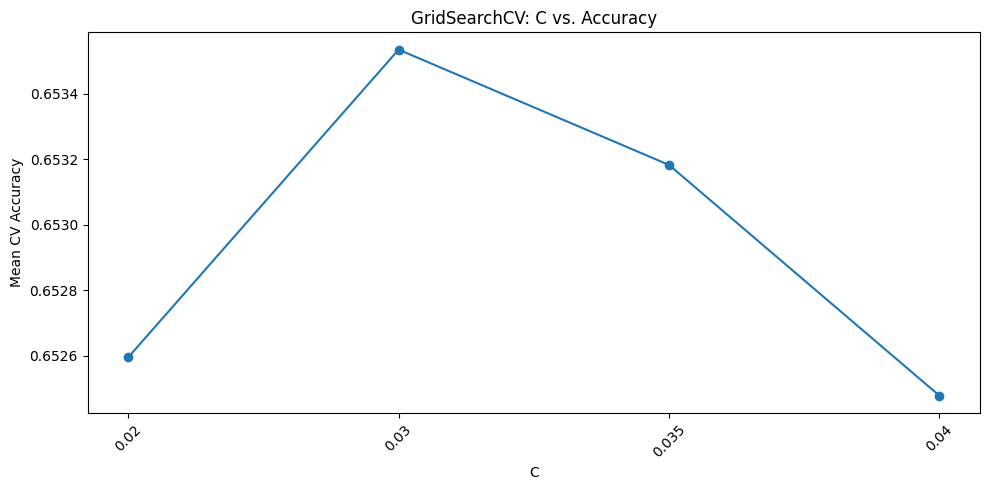

In [53]:
param0 = list(param_grid)[0]
scores = gs.cv_results_["mean_test_score"]
params = [str(d[param0]) for d in gs.cv_results_["params"]]

plt.figure(figsize = (10, 5))
plt.plot(params, scores, marker = 'o')
plt.xlabel(param0)
plt.ylabel("Mean CV Accuracy")
plt.title(f"GridSearchCV: {param0} vs. Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Evaluate on Test Set

In [54]:
results = evaluate_classifier(model, X_test, y_test)

print(f"→ Accuracy : {results['accuracy']:.4f}")
print(f"→ Precision: {results['precision']:.4f}")
print(f"→ Recall   : {results['recall']:.4f}")
print(f"→ F1-Score : {results['f1']:.4f}\n")

print("Classification Report:")
print(results["report"])

→ Accuracy : 0.6596
→ Precision: 0.6650
→ Recall   : 0.6375
→ F1-Score : 0.6510

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.68      0.67      1071
           1       0.67      0.64      0.65      1062

    accuracy                           0.66      2133
   macro avg       0.66      0.66      0.66      2133
weighted avg       0.66      0.66      0.66      2133



## Confusion Matrix Plot

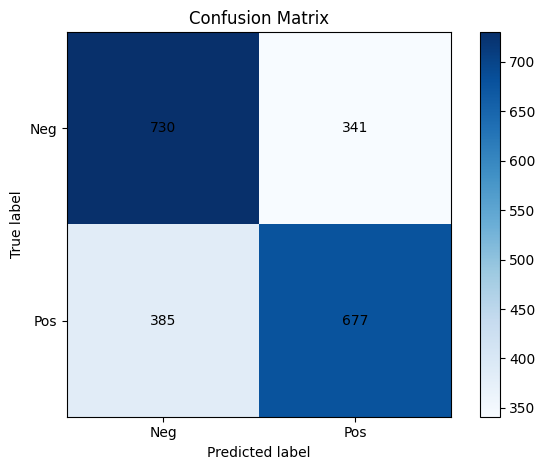

In [55]:
cm = results["confusion_matrix"]

plt.imshow(cm, interpolation = "nearest", cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0,1], ["Neg", "Pos"])
plt.yticks([0,1], ["Neg", "Pos"])

#annotate counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center')

plt.tight_layout()
plt.show()

In [56]:
## save best model
os.makedirs("../model", exist_ok=True)
save_model(model, "../model/sentiment_clf.joblib")
print("Model saved to ../model/sentiment_clf.joblib")


Model saved to ../model/sentiment_clf.joblib
